In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 41.0MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.1MB/s]


In [6]:
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/chest-xray-pneumonia"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
train_path = '/content/dataset/cnn/chest-xray-pneumonia/chest_xray/train'
test_path = '/content/dataset/cnn/chest-xray-pneumonia/chest_xray/test'
valid_path = '/content/dataset/cnn/chest-xray-pneumonia/chest_xray/val'

In [9]:
batch_size = 32

img_height = 150
img_width = 150

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [11]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)

decoder_input = test_data_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)
decoder_output = test_data_gen.flow_from_directory(train_path,target_size=(40,40),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [13]:
import tensorflow as tf

import os
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm

from keras.optimizers import SGD

In [14]:
#Creating the decoder's data
X = []
Y = []
for _ in tqdm(range(163)):
    X += list(decoder_input.next()[0])
    Y += list(decoder_output.next()[0])
X = np.array(X)
Y = np.array(Y)

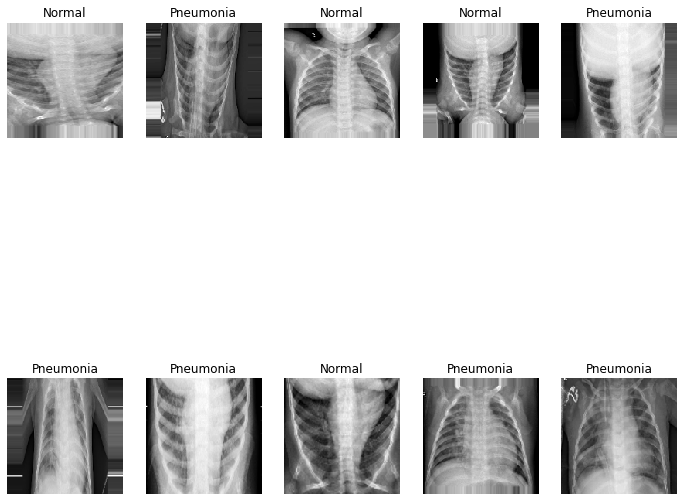

In [15]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [16]:
def SeparableConvBlock(filter_n,kernel_shape,pool_size,init,input_shape,name=None):
    
    input_layer = Input(input_shape)
    
    model = SeparableConv2D(filter_n,kernel_shape,input_shape=(img_width,img_height,1),kernel_initializer=init)(input_layer)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)

    model = SeparableConv2D(filter_n,kernel_shape,kernel_initializer=init)(model)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)


    model = MaxPooling2D(pool_size=pool_size)(model)
    
    return Model(input_layer,model,name=name),model.shape

In [17]:
input_layer = Input(shape=(img_height,img_width,1))

#Encoder

layer,shape = SeparableConvBlock(32,(3,3),(2,2),'glorot_uniform',(img_width,img_height,1),"SPB1")
enc = layer(input_layer)
layer,shape = SeparableConvBlock(64,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB2")
enc = layer(enc)
layer,shape = SeparableConvBlock(128,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB3")
enc = layer(enc)
layer,shape = SeparableConvBlock(256,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB4")
enc = layer(enc)

Encoder = Model(input_layer,enc)

#Decoder

decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(enc)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)


decoder = SeparableConv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

Decoder = Model(input_layer,decoder)
                
                
#Classifier
flatten = Flatten()(enc)
dense = Dense(128,activation='relu')(flatten)
dense = BatchNormalization()(dense)
dense = Dense(64,activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(1,activation='sigmoid')(dense)

Classifier = Model(input_layer,dense)

In [18]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 5, 5, 128)         35200     
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 5, 128)         512 

In [19]:
Decoder.compile(loss='mean_squared_error', optimizer = SGD())

In [20]:
Decoder.fit(X,Y,batch_size=batch_size,epochs=30)

Epoch 1/30
163/163 [==============================] - 63s 177ms/step - loss: 0.0475
Epoch 2/30
163/163 [==============================] - 29s 180ms/step - loss: 0.0318
Epoch 3/30
163/163 [==============================] - 29s 180ms/step - loss: 0.0276
Epoch 4/30
163/163 [==============================] - 29s 178ms/step - loss: 0.0249
Epoch 5/30
163/163 [==============================] - 29s 179ms/step - loss: 0.0229
Epoch 6/30
163/163 [==============================] - 30s 182ms/step - loss: 0.0215
Epoch 7/30
163/163 [==============================] - 29s 181ms/step - loss: 0.0206
Epoch 8/30
163/163 [==============================] - 29s 180ms/step - loss: 0.0196
Epoch 9/30
163/163 [==============================] - 29s 178ms/step - loss: 0.0192
Epoch 10/30
163/163 [==============================] - 29s 180ms/step - loss: 0.0183
Epoch 11/30
163/163 [==============================] - 29s 178ms/step - loss: 0.0177
Epoch 12/30
163/163 [==============================] - 29s 180ms/step - lo

In [21]:
predictions = Decoder.predict(X)

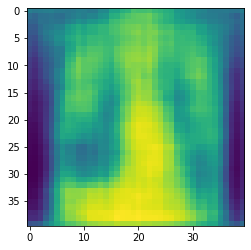

In [22]:
plt.imshow((tf.squeeze(predictions[0])))
plt.show()

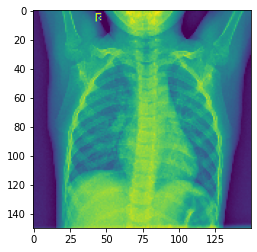

In [23]:
plt.imshow((tf.squeeze(X[0])))
plt.show()

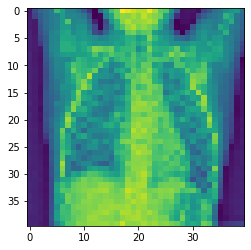

In [24]:
plt.imshow((tf.squeeze(Y[0])))
plt.show()

In [25]:
Classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8193

In [26]:
Classifier.compile(optimizer=SGD(),loss='binary_crossentropy',metrics=['accuracy'])

In [27]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [28]:
Classifier.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
163/163 [==============================] - 60s 357ms/step - loss: 0.5361 - accuracy: 0.7269 - val_loss: 0.5477 - val_accuracy: 0.6250
Epoch 2/25
163/163 [==============================] - 58s 352ms/step - loss: 0.3448 - accuracy: 0.8445 - val_loss: 1.1626 - val_accuracy: 0.5625
Epoch 3/25
163/163 [==============================] - 58s 356ms/step - loss: 0.2889 - accuracy: 0.8766 - val_loss: 0.5998 - val_accuracy: 0.6250
Epoch 4/25
163/163 [==============================] - 58s 354ms/step - loss: 0.2826 - accuracy: 0.8756 - val_loss: 0.6409 - val_accuracy: 0.6875
Epoch 5/25
163/163 [==============================] - 58s 353ms/step - loss: 0.2609 - accuracy: 0.8932 - val_loss: 0.6456 - val_accuracy: 0.6250
Epoch 6/25
163/163 [==============================] - 58s 354ms/step - loss: 0.2536 - accuracy: 0.9003 - val_loss: 0.9720 - val_accuracy: 0.6250
Epoch 7/25
163/163 [==============================] - 58s 354ms/step - loss: 0.2304 - accuracy: 0.9084 - val_loss: 0.6822 - val_ac

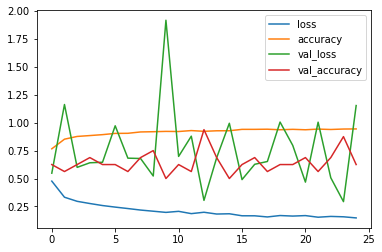

In [29]:
pd.DataFrame(Classifier.history.history).plot()

In [30]:
test_accu = Classifier.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 4s 198ms/step - loss: 0.3521 - accuracy: 0.8750
The testing accuracy is -  87.5 %


In [31]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [32]:
y_bar = np.round(Classifier.predict(test)).reshape(-1)
y_act = test.labels

In [33]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.875
ROC-AUC score:  0.9031954887218046
F1 score:  0.9078014184397163
Log Loss:  4.317354737800665


In [ ]:
Classifier.save('custom_cnn.h5')